In [7]:
from collections import Counter

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import spacy
from numpy import zeros, column_stack
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

nlp = spacy.load("en_core_web_lg")

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (20, 10)})
sns.set_style("ticks")

In [2]:
df = pandas.read_csv("troon_instagram_post_beer_attributes.csv")
df

,id,attribute,count
0,203,coffee,1
1,203,conditioned,1
2,203,imperial,1
3,203,imperial milk stout,1
4,203,milk,1
...,...,...,...
1171,296,ale,1
1172,296,hoppy ale,1
1173,293,hoppy,1
1174,293,ale,1


In [3]:
vectors = []
attributes = sorted(set(df["attribute"]))

for attribute in attributes:
    tokens = attribute.lower().split(" ")
    if len(tokens) == 1:
        vectors.append(nlp(tokens[0]).vector)
    else:
        v = nlp(tokens[0]).vector
        for t in tokens[1:]:
            if t != "&":
                v = v + nlp(t).vector
        vectors.append(v)

In [4]:
len(vectors)

238

---

In [5]:
# TODO: Come back to this.  The maximum silhouette score is terrible and agglomerative clustering didn't really help.
# cluster_sizes = []
# silhouettes = []

# for i in range(3, len(vectors) // 2):
#     cluster_sizes.append(i)
#     kmeans = KMeans(n_clusters=i, random_state=1024).fit(vectors)
#     silhouettes.append(silhouette_score(vectors, kmeans.labels_, random_state=1024, metric="cosine"))
                       
# g = sns.lineplot(x=cluster_sizes, y=silhouettes)

In [6]:
# cluster_sizes[silhouettes.index(max(silhouettes))]

In [7]:
# kmeans = KMeans(n_clusters=cluster_sizes[silhouettes.index(max(silhouettes))], random_state=1024).fit(vectors)

# tsne = TSNE(n_components=2, random_state=1024, metric="cosine")
# reduced = pandas.DataFrame(tsne.fit_transform(kmeans.transform(vectors)))
# ax = sns.scatterplot(x=reduced[0], y=reduced[1], hue=kmeans.labels_, s=100, palette="tab10")
# plt.show()

In [8]:
# sorted(list(zip(attributes, kmeans.labels_)), key=lambda x : x[1])

---

In [5]:
attribute_vectors = dict(zip(attributes, vectors))
beer_ids = sorted(set(df["id"]))
beer_vectors = []

for beer_id in beer_ids:
    vector = zeros(300)
    for (i, row) in df[df["id"] == beer_id].iterrows():
        for j in range(0, row["count"]):
            vector = vector + attribute_vectors[row["attribute"]]
    beer_vectors.append(vector)

Text(0,0.5,'Silhouette Score')

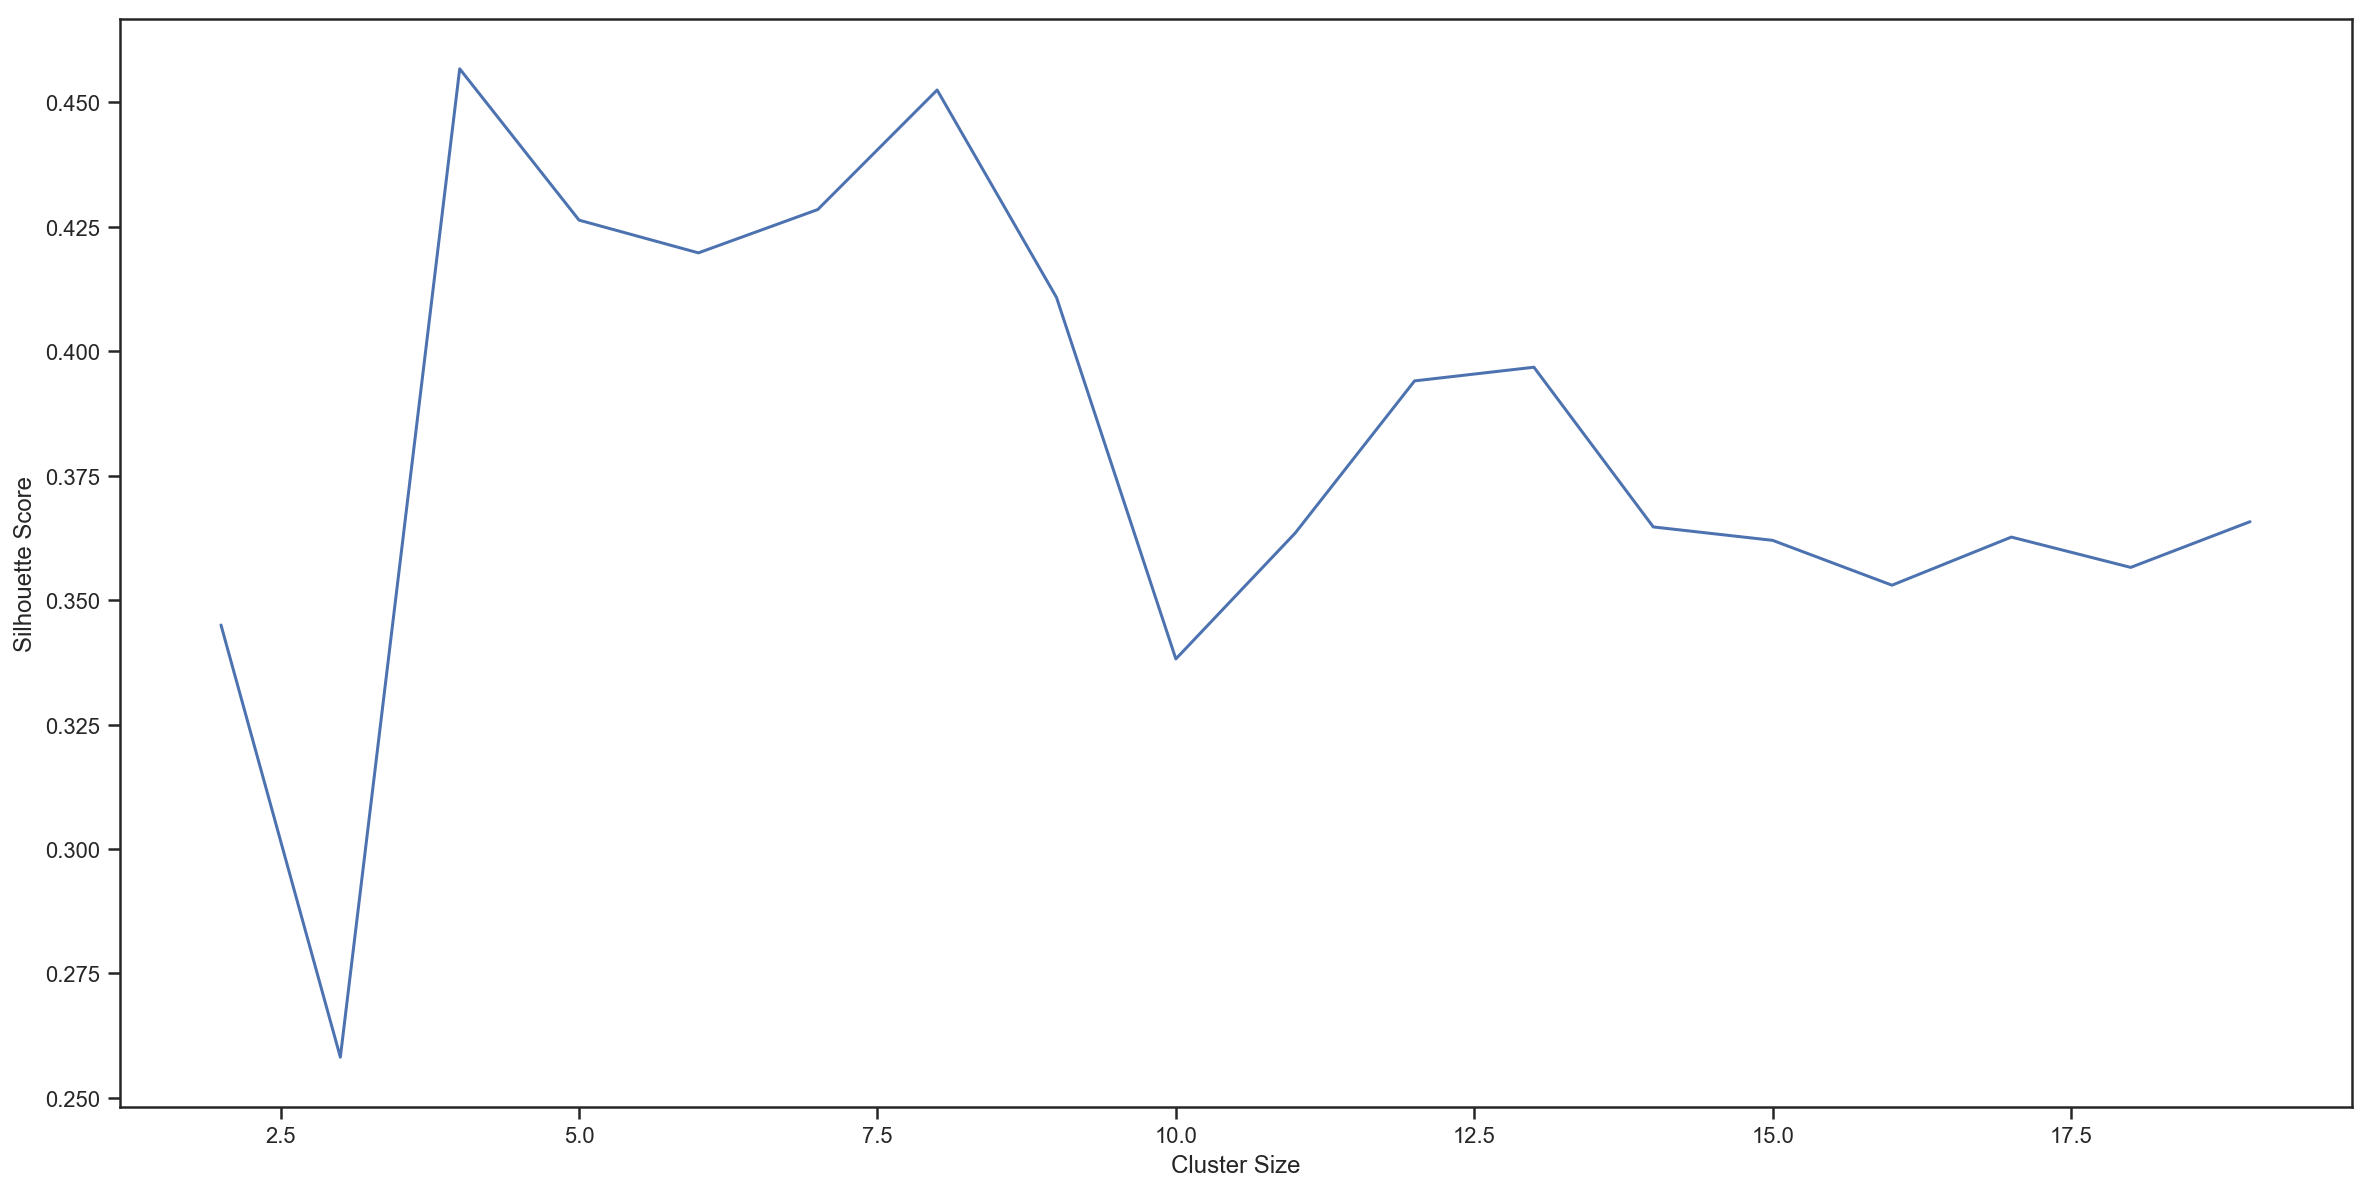

In [8]:
cluster_sizes = []
silhouettes = []

for i in range(2, 20):
    cluster_sizes.append(i)
    kmeans = KMeans(n_clusters=i, random_state=1024).fit(beer_vectors)
    silhouettes.append(silhouette_score(beer_vectors, kmeans.labels_, random_state=1024, metric="cosine"))
                       
g = sns.lineplot(x=cluster_sizes, y=silhouettes)
g.set_xlabel("Cluster Size")
g.set_ylabel("Silhouette Score")

In [9]:
best_cluster_size = cluster_sizes[silhouettes.index(max(silhouettes))]
#best_cluster_size = 4
best_cluster_size

4

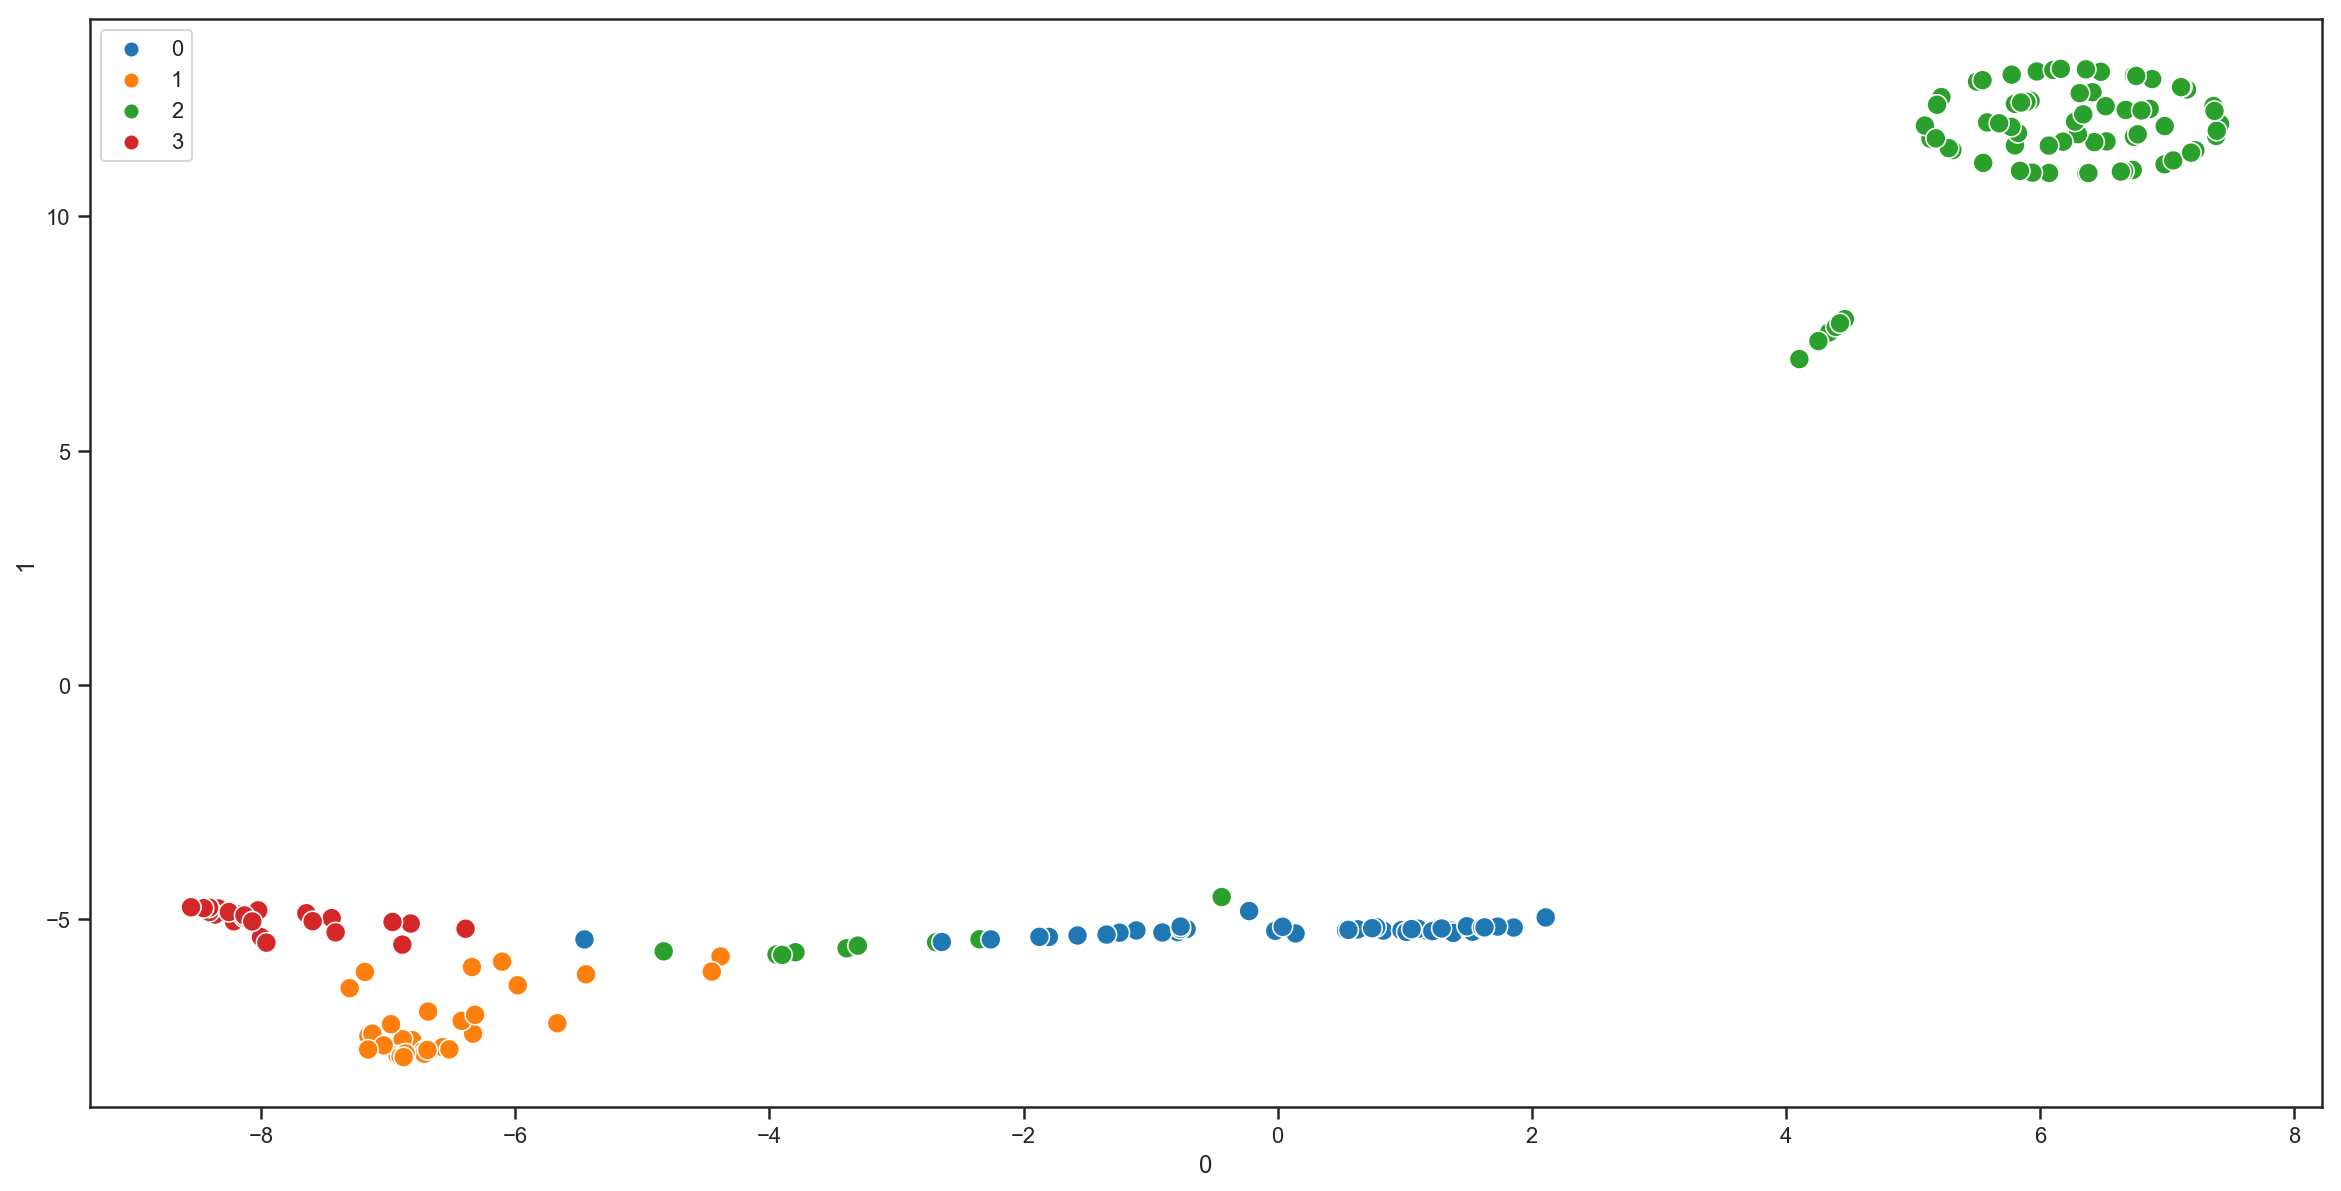

In [10]:
kmeans = KMeans(n_clusters=best_cluster_size, random_state=1024).fit(beer_vectors)

tsne = TSNE(n_components=2, random_state=1024, metric="cosine", learning_rate=100, square_distances=True)
reduced = pandas.DataFrame(tsne.fit_transform(kmeans.transform(beer_vectors)))
ax = sns.scatterplot(x=reduced[0], y=reduced[1], hue=kmeans.labels_, s=100, palette="tab10")
plt.show()

In [11]:
cluster_attributes = {l : [] for l in set(kmeans.labels_)}
reduced["id"] = beer_ids
reduced["cluster_id"] = kmeans.labels_

for (i, row) in reduced.iterrows():
    attributes = list(df[df["id"] == row["id"]]["attribute"])
    cluster_attributes[row["cluster_id"]] += attributes

appearing_in_all = None
for cluster_id in cluster_attributes:
    if appearing_in_all is None:
        appearing_in_all = set(cluster_attributes[cluster_id])
    else:
        appearing_in_all = appearing_in_all.intersection(set(cluster_attributes[cluster_id]))
        
print(appearing_in_all)
    
{c : sorted(Counter([a for a in cluster_attributes[c] if a not in appearing_in_all]).items(), 
            key=lambda x : x[1], reverse=True) for c in cluster_attributes}

{'conditioned', 'ale', 'vanilla', 'madagascar vanilla', 'refermented', 'hoppy', 'lactose'}


{0: [('hopped', 19),
  ('ipa', 9),
  ('lupulin', 6),
  ('powder', 6),
  ('@rojosroastery', 5),
  ('session', 5),
  ('simcoe', 4),
  ('mosaic', 4),
  ('citra', 4),
  ('coffee', 3),
  ('enigma', 3),
  ('galaxy', 3),
  ('american', 2),
  ('oats', 2),
  ('azacca', 2),
  ('session ipa', 2),
  ('vic secret', 2),
  ('amarillo', 2),
  ('keller', 2),
  ('wheat', 2),
  ('pineapple', 2),
  ('triple', 2),
  ('triple ipa', 2),
  ('dipa', 2),
  ('smoothie', 2),
  ('medusa', 2),
  ('lager', 2),
  ('imperial', 2),
  ('imperial stout', 2),
  ('stout', 2),
  ('@thereferendbierblendery', 1),
  ('american blonde', 1),
  ('blonde', 1),
  ('motueka', 1),
  ('grist', 1),
  ('organic', 1),
  ('el dorado', 1),
  ('yeast', 1),
  ('carrion', 1),
  ('collaboration', 1),
  ('american varietals', 1),
  ('fresh', 1),
  ('cacao', 1),
  ('cacao nibs', 1),
  ('ochochoque', 1),
  ('pastrywine', 1),
  ('quilla', 1),
  ('kölsch', 1),
  ('palo santo wood', 1),
  ('dryhopped', 1),
  ('hoped', 1),
  ('nelson', 1),
  ('nelson

In [12]:
cluster_names = {0 : "IPAs", 1 : "Sours", 2 : "Hoppy Ales", 3 : "Stouts"}

In [13]:
reduced["cluster_name"] = reduced["cluster_id"].apply(lambda x : cluster_names[x])

In [14]:
reduced["attributes"] = reduced["id"].apply(lambda x : ", ".join(sorted(df[df["id"] == x]["attribute"])))
reduced

,0,1,id,cluster_id,cluster_name,attributes
0,7.368222,12.242451,0,2,Hoppy Ales,"ale, hoppy, hoppy ale"
1,6.364674,10.920456,1,2,Hoppy Ales,"ale, hoppy, hoppy ale"
2,5.974886,13.098060,2,2,Hoppy Ales,"ale, hoppy, hoppy ale"
3,4.470599,7.822914,3,2,Hoppy Ales,"ale, honey, hoppy, hoppy ale"
4,4.340634,7.524896,6,2,Hoppy Ales,"ale, hoppy, hoppy ale, lactose, peach, referme..."
...,...,...,...,...,...,...
193,7.048474,11.197242,292,2,Hoppy Ales,"ale, hoppy, hoppy ale"
194,6.163976,13.153703,293,2,Hoppy Ales,"ale, hoppy, hoppy ale"
195,7.189397,11.363531,294,2,Hoppy Ales,"ale, hoppy, hoppy ale"
196,-6.316350,-7.056213,295,1,Sours,"ale, conditioned, guava, lactose, refermented,..."


In [15]:
reduced.to_csv("troon_TSNE_kmeans_clusters.csv", index=False)